In [23]:
import csv
import json
import os
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from benchmark.dataset.lmdb_dataset import LMDBDataset


In [24]:
BASE_PATH = '/home/jluesch/Documents/data'
DS_PATH = os.path.join(BASE_PATH, 'schuerch_dataset_lmdb')

dataset_split = os.path.join(DS_PATH, 'splits', 'schuerch_dataset_split.csv')
label_dict = os.path.join(DS_PATH, 'label_dict.json')
dataset_path = os.path.join(DS_PATH, 'lmdb')

# load split .csv
split_df = pd.read_csv(dataset_split)
label_dict = json.load(open(label_dict))

# load dataset
datasets = {}
splits = ["train", "valid", "test"]
for split in splits:
    include_fovs = split_df[split_df["train_test_val_split"] == split]["sample_name"].tolist()
    print(split, 'num_FOVs:', len(include_fovs), include_fovs[:4])
    dataset = LMDBDataset(path=dataset_path, include_sample_names=include_fovs) #include_tile_names=include_fovs)
    datasets[split] = dataset


train num_FOVs: 74 ['reg002_A.hdf', 'reg002_B.hdf', 'reg004_A.hdf', 'reg004_B.hdf']
valid num_FOVs: 16 ['reg003_A.hdf', 'reg003_B.hdf', 'reg007_A.hdf', 'reg007_B.hdf']
test num_FOVs: 19 ['reg001_A.hdf', 'reg001_B.hdf', 'reg005_A.hdf', 'reg005_B.hdf']


In [25]:
one_pct_tiles = int(0.01 * len(datasets['train']))
one_pct_tiles

46

In [26]:
label_dict = {int(k): v for k, v in label_dict.items()}
del label_dict[0]
label_dict

{1: 'B cells',
 2: 'Macrophages/Monocytes',
 3: 'Adipocytes',
 4: 'Dendritic cells',
 5: 'T cells',
 6: 'Granulocytes',
 7: 'NK cells',
 8: 'Nerves',
 9: 'Plasma cells',
 10: 'Smooth muscle',
 11: 'Stroma',
 12: 'Tumor cells',
 13: 'Vasculature/Lymphatics',
 14: 'Other cells'}

In [27]:
num_classes = max(label_dict.keys())
print('num_classes:', num_classes)

num_classes: 14


In [28]:
def get_unique_counts(semantic_mask):
    unique, counts = np.unique(semantic_mask, return_counts=True)
    unique_dict = {int(k): int(v) for k, v in zip(unique, counts)}
    return unique_dict

def update_c_type_freq(unique_dict, c_type_freq):
    for un, ct in unique_dict.items():
        un = int(un)
        if un > 0:
            c_type_name = label_dict[un]
            c_type_freq[c_type_name] += int(ct)

def remove_pad(x):
    res_x = []
    nonzero_mask = x != 0
    print(nonzero_mask[0, :, :].shape)
    for i in range(x.shape[0]):
        if x[i].sum() == 0:
            continue

        res_x.append(np.trim_zeros(x[i]))

    res_x = np.stack(res_x)
    return res_x, nonzero_mask[0, :, :]

def normalize(x):
    return x / x.max()
    #return (x - x.min()) / (x.max() - x.min())

def plot_el(el, rare_c_types):
    if len(rare_c_types) > 1:
        title = ', '.join(itemgetter(*rare_c_types)(label_dict)) + ' in ' + el['tile_name']
        print('found', title)
        img, nonzero_mask = remove_pad(el["image"])
        sem_mask = el["semantic_mask"][nonzero_mask == 1]

        rare_c = sem_mask == rare_c_types[0]

        f, a = plt.subplots(1, 3)
        f.set_size_inches(10,5)
        f.suptitle(title)
        rare_c = 2 * rare_c
        rare_c = rare_c | (sem_mask == rare_c_types[1])
        a[0].imshow(normalize(img).transpose(1,2,0))
        a[1].imshow(normalize(img).transpose(1,2,0))
        a[1].imshow(rare_c.reshape(img.shape[1], img.shape[2], 1), alpha=0.4)
        a[2].imshow(sem_mask.reshape(img.shape[1], img.shape[2], 1))
        for ax in a:
            ax.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f'tile_{el["tile_name"]}.png'), bbox_inches='tight')
        plt.show()

do_vis = False
c_type_freq_all = []
tile_list = []
sel_c_types = True
selected_tmas = []
prev_rare_count = 0
# from least to most rare
rare_c_type_idx = [7,4]
cand_unique_dict = {}
out_dir = '/home/jluesch/Documents/output_dir/c_types'

for split in splits:
    print(split, 'dataset length:', len(datasets[split]))
    dataset = datasets[split]
    c_type_freq = dict.fromkeys(label_dict.values(), 0)

    for i, el in enumerate(dataset):
        if i == 0: #init
            prev_tma = el["sample_name"]
            candidate_tile_name = el["tile_name"]

        unique_dict = get_unique_counts(el["semantic_mask"])
        if split == 'train' and i % 10000 == 0:
            print(unique_dict)

        if not sel_c_types or split != 'train':
            tile_list.append((el["tile_name"], split))
            update_c_type_freq(unique_dict, c_type_freq)
        else:
            # select the tile in the tma with the most abundant rare cell types
            curr_tma = el["sample_name"]
            if curr_tma != prev_tma: # new tma, update frequency list
                prev_rare_count = 0
                tile_list.append((candidate_tile_name, split))
                selected_tmas.append(prev_tma)
                update_c_type_freq(cand_unique_dict, c_type_freq)
                prev_tma = curr_tma
                if len(tile_list) >= one_pct_tiles:
                    break

            rare_c_types = list(set(rare_c_type_idx) & set(unique_dict.keys()))
            if len(rare_c_types) > 0:
                if do_vis:
                    plot_el(el, rare_c_types)

                curr_rare_count = np.sum(itemgetter(*rare_c_types)(unique_dict))
                if curr_rare_count > prev_rare_count or len(rare_c_types) > 1:
                    prev_rare_count = curr_rare_count
                    candidate_tile_name = el["tile_name"]
                    cand_unique_dict = unique_dict

    c_type_freq_all.append(c_type_freq)

print(f'Selected {len(tile_list)} tiles from {len(list(set(selected_tmas)))} TMAs')


train dataset length: 4662
{0: 41906, 2: 3058, 5: 339, 6: 305, 10: 3589, 11: 979}
valid dataset length: 1008
test dataset length: 1197
Selected 2251 tiles from 46 TMAs


In [29]:
out_dir = '/home/jluesch/Documents/output_dir/c_types'
label = 'train_balanced_tile_split_one_pct'
out_file = os.path.join(out_dir, f'{label}.csv')

with open(out_file, 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['sample_name', 'train_test_val_split'])
    for tile, split in tile_list:
       writer.writerow([tile, split])


In [31]:
print('Cell Numbers:')
print(f'train: {sum(c_type_freq_all[0].values())}')
print(f'val:   {sum(c_type_freq_all[1].values())}')
print(f'test:  {sum(c_type_freq_all[2].values())}')
print(f'ALL:   {sum(c_type_freq_all[0].values()) + sum(c_type_freq_all[1].values()) + sum(c_type_freq_all[2].values())}')

Cell Numbers:
train: 853733
val:   11838635
test:  13528654
ALL:   26221022


In [32]:
c_type_freq = dict(sorted(c_type_freq_all[0].items(), key=lambda item: item[1], reverse=True))
c_type_freq

{'Smooth muscle': 156667,
 'Tumor cells': 150561,
 'Macrophages/Monocytes': 130718,
 'B cells': 118915,
 'T cells': 110337,
 'Granulocytes': 60716,
 'Stroma': 41099,
 'Vasculature/Lymphatics': 38238,
 'Dendritic cells': 22630,
 'Other cells': 14541,
 'Plasma cells': 3732,
 'Adipocytes': 2770,
 'NK cells': 1535,
 'Nerves': 1274}

In [33]:
print('Total nb of cells', sum(c_type_freq.values()))

Total nb of cells 853733


In [34]:
out_file = os.path.join(out_dir, f'c_train_{label}_types.csv')

with open(out_file, 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in c_type_freq.items():
       writer.writerow([key, value])

['Vasculature/Lymphatics', 'Tumor cells', 'T cells', 'Stroma', 'Smooth muscle', 'Plasma cells', 'Other cells', 'Nerves', 'NK cells', 'Macrophages/Monocytes', 'Granulocytes', 'Dendritic cells', 'B cells', 'Adipocytes']


[]

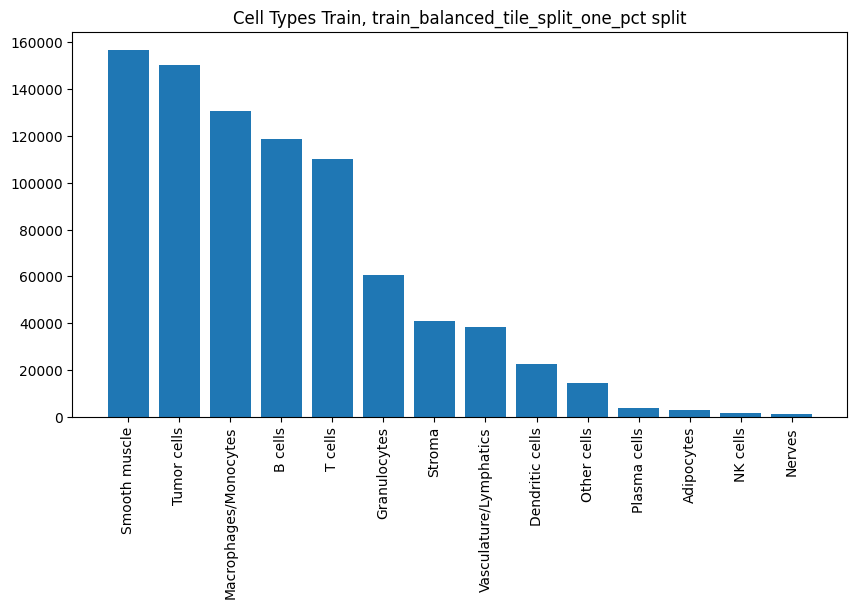

In [35]:
f, a = plt.subplots(1, 1, figsize=(10, 5))

x_vals = sorted(c_type_freq.keys(), reverse=True)

a.bar(c_type_freq.keys(), c_type_freq.values())
a.set_xticks(list(c_type_freq.keys()))
print(x_vals)
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_title(f'Cell Types Train, {label} split')

out_fig = os.path.join(out_dir, f'c_types_{label}.png')
plt.savefig(out_fig, bbox_inches='tight')
plt.plot()
